# Import libraries

In [137]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.utils import pad_sequences
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

import seaborn as sns
import re
import string
import imblearn
from imblearn.over_sampling import SMOTE

# save model
import joblib

# Read input dataset

In [78]:
l_dataset = pd.read_csv("../source-data/L.csv", delimiter=";", encoding="windows-1251")
c_dataset = pd.read_csv("../source-data/C.csv", delimiter=";", encoding="windows-1251")

# Overview dataset

In [79]:
# shape dataset
l_dataset.shape, c_dataset.shape

((50990, 6), (28978, 6))

In [80]:
l_dataset.head()

,Number,Date,UID,Desc,Group,Cat
0,1060141,12.03.2021 11:33,7b5dc3bb-1dcb-4954-9f3c-c5dc9c7d45d2,Не горит лампа в коридоре,Управление домом,"Разбитые стекла, сорванные створки оконных пер..."
1,1112641,2021-05-27 14:16:23.000,8361aa95-b693-444e-a212-8e1da60e8fde,кривой дорожный знак,Дороги,Общие вопросы
2,1112656,31.05.2021 12:07,7ac9fbb2-f72f-471d-9a10-ff191b9be927,Провал колодца на пешеходной дороге,Канализация,Общие вопросы
3,1112657,31.05.2021 12:12,3777d635-b4da-4897-9b89-2ba1aa44d891,Низкие температурные параметры ГВС,ГВС,Общие вопросы
4,1112668,01.06.2021 11:17,badc0911-6201-4a4e-963e-a63a6a3d408c,запах канализации,Канализация,Общие вопросы


In [81]:
c_dataset.head()

,Number,Date,UID,Desc,Group,Cat
0,1346291,01.01.2023 2:10,e87b2cfa-6159-4aa2-b789-3974a01e0b0a,Застряли в лифте,NaN,NaN
1,1346298,01.01.2023 9:09,d6257b7b-d68c-449f-aef3-6c4af1a2d78f,Течь батареи в спальной,NaN,NaN
2,1346301,01.01.2023 10:37,927aeffe-0842-4894-8ada-0a91ccdf1692,Течь сверху по стояку,NaN,NaN
3,1346303,01.01.2023 10:56,9884e4a6-2ce4-485b-913d-8e75c7779302,Течь КНС в 3 подвале,NaN,NaN
4,1346306,01.01.2023 11:44,4593c91a-8b75-46e4-83e5-557d730abea0,Течь кровли (забита ливневка),NaN,NaN


In [82]:
l_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50990 entries, 0 to 50989
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Number  50990 non-null  int64 
 1   Date    50990 non-null  object
 2   UID     50990 non-null  object
 3   Desc    50988 non-null  object
 4   Group   50990 non-null  object
 5   Cat     50990 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.3+ MB


In [83]:
# check NaN
l_dataset.isna().sum(), c_dataset.isna().sum()

(Number    0
 Date      0
 UID       0
 Desc      2
 Group     0
 Cat       0
 dtype: int64,
 Number        0
 Date          0
 UID           0
 Desc          0
 Group     28978
 Cat       28978
 dtype: int64)

In [84]:
# get index of NaN 'Desc' row of L dataset
idx_na = l_dataset[l_dataset["Desc"].isna()].index
idx_na

Index([36, 158], dtype='int64')

In [85]:
# remove nan desc
l_dataset = l_dataset[~l_dataset.index.isin(idx_na)]
l_dataset = l_dataset.reset_index(drop=True)
l_dataset.shape

(50988, 6)

In [86]:
# check balance of data
l_dataset['Group'].value_counts()

Group
Управление домом                 47005
ГВС                               1729
Лифты                             1269
Домофоны                           859
Общие вопросы                       47
Благоустройство                     34
Бродячие животные                   14
Отопление                            5
ХВС                                  4
Электроэнергия                       3
Сантехника                           3
Канализация                          3
Газоснабжение                        2
Дороги                               2
Водоотведение                        2
Ливневки                             1
Вентиляция                           1
Мусоропровод                         1
Уборка  придомовой территории        1
Работа МФЦ                           1
Диспетчеризация                      1
Приборы учета                        1
Name: count, dtype: int64

In [87]:
l_dataset['Cat'].value_counts()

Cat
Сантехника                                                            12401
Отопление (Отсутствие)                                                 5546
Общие вопросы                                                          4617
ГВС (Несоответствие температурных параметров)                          4013
Канализация                                                            3817
                                                                      ...  
Ликвидация воздушных пробок                                               1
Отключение стояков отопления                                              1
Устранение аварии                                                         1
Течи в водопроводных кранах и в кранах сливных бачков при унитазах        1
Подключение к диспетчеризации                                             1
Name: count, Length: 97, dtype: int64

In [88]:
# Count nums of label just have 1
print('1: ', sum(l_dataset['Cat'].value_counts() == 1))
# Count nums of label less than 10
print('<10: ', sum(l_dataset['Cat'].value_counts() < 10))
# Count nums of label less than 100
print('<100: ', sum(l_dataset['Cat'].value_counts() < 100))

1:  12
<10:  35
<100:  64


# Data Augmentation by googletrans + textattack

In [89]:
from textattack.augmentation import EasyDataAugmenter
from textattack.augmentation import WordNetAugmenter
from textattack.augmentation import EmbeddingAugmenter
from textattack.augmentation import CheckListAugmenter
from textattack.augmentation import CLAREAugmenter

import asyncio
import multiprocessing

In [90]:
from deep_translator import GoogleTranslator,   \
                            PonsTranslator,     \
                            LingueeTranslator,  \
                            MyMemoryTranslator, \
                            YandexTranslator # can not register api key
MY_DEEPTRANS_API = '5046fb77012286730dd527cb9f2d8e30'

In [91]:
LANGUAGES = {
    'mt': 'maltese',
    'en': 'english', 
    'de': 'german', 
    'bg': 'bulgarian', 
    'pl': 'polish', 
    'pt': 'portuguese', 
    'hu': 'hungarian', 
    'ro': 'romanian', 
    'ru': 'russian', 
    'nl': 'dutch', 
    'slovakian': 'slovakian', 
    'el': 'greek', 
    'sl': 'slovenian', 
    'da': 'danish', 
    'it': 'italian', 
    'es': 'spanish', 
    'fi': 'finnish', 
    'chinese': 'chinese', 
    'zh-cn': 'chinese (simplified)',
    'zh-tw': 'chinese (traditional)',
    'fr': 'french', 
    'cs': 'czech', 
    'laotian': 'laotian', 
    'sv': 'swedish', 
    'lv': 'latvian', 
    'et': 'estonian', 
    'ja': 'japanese'
}

In [92]:
languages = list(LANGUAGES.keys())
# aug_methods = ['easy', 'wordnet', 'embedding', 'checklist']
aug_methods = ['checklist', 'embedding', 'wordnet']
translators = ['google']#, 'pons', 'linguee',
              #'mymemory', 'libre'] # 'yandex'

async def rand_trans_utils(huge=False):
    idx_lang = round(np.random.uniform(0, len(languages) - 1))
    idx_aug_method = round(np.random.uniform(0, len(aug_methods) - 1))
    idx_trans = round(np.random.uniform(0, len(translators) - 1))

    # get aug method
    if aug_methods[idx_aug_method] == 'easy':
        rand_aug_method = EasyDataAugmenter()
    elif aug_methods[idx_aug_method] == 'wordnet':
        rand_aug_method = WordNetAugmenter()
    elif aug_methods[idx_aug_method] == 'checklist':
        rand_aug_method = CheckListAugmenter(pct_words_to_swap=0.2, transformations_per_example=3)
    elif aug_methods[idx_aug_method] == 'clare':
        rand_aug_method = CLAREAugmenter()
    else:
        rand_aug_method = EmbeddingAugmenter()
        
    translator = None
    # get translator
    if translators[idx_trans] == 'google':
        translator = GoogleTranslator
    # elif translators[idx_trans] == 'pons' and not huge:
    #     translator = PonsTranslator
    # elif translators[idx_trans] == 'linguee' and not huge:
    #     translator = LingueeTranslator
    # elif translators[idx_trans] == 'mymemory':
    #     translator = MyMemoryTranslator
    else:
        translator = GoogleTranslator
        
    return languages[idx_lang], rand_aug_method, translator, idx_trans
    

In [93]:
async def back_translate(sequence, label, PROB = 1):
    output_sequence = []
    #store original language so we can convert back
    org_lang = 'ru'
    trans_lang = 'en'

    huge = False
    if len(sequence) > 50:
        huge = True
        
    #randomly choose language to translate sequence to
    target_lang, aug_method, translator, idx_trans = await rand_trans_utils(huge)
    translated = None
    aug_translated = None
    #translate to english, that is transform language
    try:
        translated = translator(source=LANGUAGES[org_lang], target=LANGUAGES[trans_lang]).translate(sequence)
        # print(aug_method.augment(translated))
        aug_translated = aug_method.augment(translated)
    except:
        print(f'{translators[idx_trans]} no support translate to {LANGUAGES[trans_lang]}')
        pass
        
    if translated:
        for se in aug_translated:
            translated_next = None
            if trans_lang != target_lang:
                try: 
                    translated_next = translator(source=LANGUAGES[trans_lang], target=LANGUAGES[target_lang]).translate(se)
                except:
                    # print(f'{translators[idx_trans]} no support translate to {LANGUAGES[target_lang]}')
                    break
            #translate back to original language
            if translated_next:
                translated_back = None
                try:
                    translated_back = translator(source=LANGUAGES[target_lang], target=LANGUAGES[org_lang]).translate(translated_next)
                except:
                    print(f'Finally, {translators[idx_trans]} no support translate to {LANGUAGES[org_lang]}')
                    pass
                
                #apply with certain probability
                if np.random.uniform(0, 1) <= PROB:
                    output_sequence.append([translated_back] + label)
    else:
        output_sequence = output_sequence
    output_sequence = [list(x) for x in set(tuple(x) for x in output_sequence)]
    return output_sequence


In [94]:
#check performance
text = l_dataset['Desc'][10] # sample text
group = l_dataset['Group'][10]
cate = l_dataset['Cat'][10]
label = [group, cate]

aug_result = []
while len(aug_result) < 20: # with 20 data more
    output = await back_translate(text, label)
    aug_result.extend(output)

[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jeremie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [95]:
aug_result[:5]

[['Необходимо обрезать сухие ветки уличных деревьев. промышленная, 140, 81, 171',
  'Благоустройство',
  'Общие вопросы'],
 ['Необходимо обрезать сухие ветки уличных деревьев. Индустриальная, 141, 113, 164',
  'Благоустройство',
  'Общие вопросы'],
 ['Необходимо обрезать сухие ветки уличных деревьев. Индустриальная, 53, 52, 104',
  'Благоустройство',
  'Общие вопросы'],
 ['Сухими руками следует обрезать деревья вдоль проезжей части улицы. Промышленная, 85, 87, 91',
  'Благоустройство',
  'Общие вопросы'],
 ['Необходимо срезать сухие ветки на дереве вдоль проезжей части. Промышленная, 85, 87, 91',
  'Благоустройство',
  'Общие вопросы']]

**Applies to Group labels with quantities less than 100**

In [96]:
printf('Error - No need more')

NameError: name 'printf' is not defined

In [ ]:
group_labels_less = l_dataset['Group'].value_counts()[l_dataset['Group'].value_counts() <= 100]

In [ ]:
for i in range(len(l_dataset)):
    if l_dataset.loc[i, 'Group'] in group_labels_less.index:
        text = l_dataset.loc[i, 'Desc']
        group = l_dataset.loc[i, 'Group']
        cate = l_dataset.loc[i, 'Cat']
        cur_nums = group_labels_less[l_dataset.loc[i, 'Group']]

        label = [group, cate]

        if cur_nums > 10:
            more = 5
        else:
            more = 50
            
        aug_result = []
        while len(aug_result) < more: # with 20 data more
            output = await back_translate(text, label)
            aug_result.extend(output)

        # convert to list
        aug_result = list(list(x) for x in aug_result)
        l_dataset = pd.concat([l_dataset, pd.DataFrame(aug_result, columns=['Desc', 'Group', 'Cat'])], ignore_index=True)

In [ ]:
l_dataset.shape

In [ ]:
l_dataset['Group'].value_counts()

**Augmentation for category**

In [ ]:
cat_labels_less = l_dataset['Cat'].value_counts()[l_dataset['Cat'].value_counts() <= 100]
cat_labels_less[:10], cat_labels_less.shape

In [ ]:
# with no parallel, it takes more than x hours

for i in range(len(l_dataset)):
    if l_dataset.loc[i, 'Cat'] in cat_labels_less.index:
        text = l_dataset.loc[i, 'Desc']
        group = l_dataset.loc[i, 'Group']
        cate = l_dataset.loc[i, 'Cat']
        cur_nums = cat_labels_less[l_dataset.loc[i, 'Cat']]

        label = [group, cate]

        if cur_nums > 50:
            more = 2
        elif cur_nums >= 10:
            more = 5
        else:
            more = 50
            
        aug_result = []
        while len(aug_result) < more: # with 20 data more
            output = await back_translate(text, label)
            aug_result.extend(output)

        # convert to list
        aug_result = list(list(x) for x in aug_result)
        l_dataset = pd.concat([l_dataset, pd.DataFrame(aug_result, columns=['Desc', 'Group', 'Cat'])], ignore_index=True)


In [ ]:
l_dataset['Cat'].value_counts()

In [ ]:
# save to csv file
l_dataset.to_csv('../source-data/L_augment.csv', index=False)

# Cleaning data after augmentation

In [97]:
l_dataset_aug = pd.read_csv("../source-data/L_augment.csv")

In [98]:
l_dataset_aug['Desc and Group'] = l_dataset_aug['Desc'] + '. ' + l_dataset_aug['Group']

In [99]:
l_dataset_aug.head()

,Number,Date,UID,Desc,Group,Cat,Desc and Group
0,1060141.0,12.03.2021 11:33,7b5dc3bb-1dcb-4954-9f3c-c5dc9c7d45d2,Не горит лампа в коридоре,Управление домом,"Разбитые стекла, сорванные створки оконных пер...",Не горит лампа в коридоре. Управление домом
1,1112641.0,2021-05-27 14:16:23.000,8361aa95-b693-444e-a212-8e1da60e8fde,кривой дорожный знак,Дороги,Общие вопросы,кривой дорожный знак. Дороги
2,1112656.0,31.05.2021 12:07,7ac9fbb2-f72f-471d-9a10-ff191b9be927,Провал колодца на пешеходной дороге,Канализация,Общие вопросы,Провал колодца на пешеходной дороге. Канализация
3,1112657.0,31.05.2021 12:12,3777d635-b4da-4897-9b89-2ba1aa44d891,Низкие температурные параметры ГВС,ГВС,Общие вопросы,Низкие температурные параметры ГВС. ГВС
4,1112668.0,01.06.2021 11:17,badc0911-6201-4a4e-963e-a63a6a3d408c,запах канализации,Канализация,Общие вопросы,запах канализации. Канализация


In [100]:
# Remove duplicated rows
l_dataset_aug = l_dataset_aug.drop_duplicates(subset=['Desc', 'Group', 'Cat'], keep='first')
l_dataset_aug.shape

(40482, 7)

In [101]:
l_dataset_aug['Length'] = l_dataset_aug['Desc'].apply(lambda x: len(x))

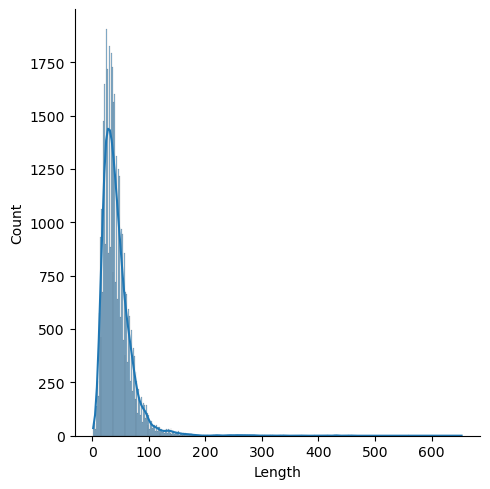

In [102]:
sns.displot(l_dataset_aug['Length'], kde=True)

## Preprocessing

In [103]:
def convert_to_lower(text):
    return text.lower()
    
def remove_numbers(text):
    return re.sub(pattern=r'\d+', repl=" ", string=text)
    
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("russian"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remmove_extra_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def preprocessing_desc():
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc'].apply(lambda x: convert_to_lower(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_numbers(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_punctuation(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remove_stopwords(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: remmove_extra_spaces(x))
    l_dataset_aug['Desc clean'] = l_dataset_aug['Desc clean'].apply(lambda x: lemmatizing(x))
    l_dataset_aug['Length after clean'] = l_dataset_aug['Desc clean'].apply(lambda x: len(x))

def preprocessing_desc_and_group():
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc and Group'].apply(lambda x: convert_to_lower(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_numbers(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_punctuation(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remove_stopwords(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: remmove_extra_spaces(x))
    l_dataset_aug['Desc Group clean'] = l_dataset_aug['Desc Group clean'].apply(lambda x: lemmatizing(x))

In [104]:
# Before preprocessing
l_dataset_aug['Desc'][:5]

0              Не горит лампа в коридоре
1                   кривой дорожный знак
2    Провал колодца на пешеходной дороге
3     Низкие температурные параметры ГВС
4                      запах канализации
Name: Desc, dtype: object

In [105]:
preprocessing_desc()
l_dataset_aug['Desc clean'][:5]

0                  горит лампа коридоре
1                  кривой дорожный знак
2      провал колодца пешеходной дороге
3    низкие температурные параметры гвс
4                     запах канализации
Name: Desc clean, dtype: object

In [106]:
preprocessing_desc_and_group()

# After preprocessing
l_dataset_aug['Desc Group clean'][:5]

0           горит лампа коридоре управление домом
1                     кривой дорожный знак дороги
2    провал колодца пешеходной дороге канализация
3          низкие температурные параметры гвс гвс
4                   запах канализации канализация
Name: Desc Group clean, dtype: object

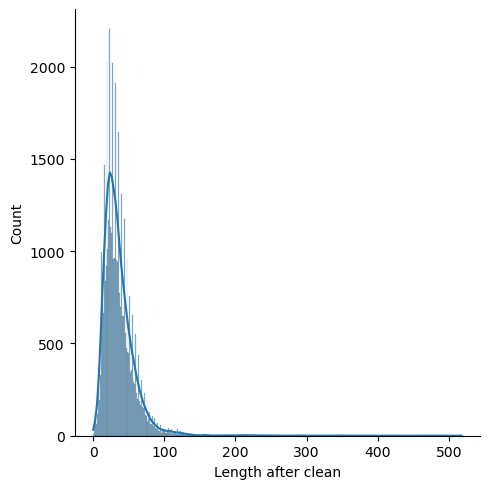

In [107]:
sns.displot(l_dataset_aug['Length after clean'], kde=True)

# Defined multiclass-logloss

In [108]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """
    Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    if len(actual.shape) == 1:
        tmp = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            tmp[i, val] = 1
        actual = tmp

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

# Prepare training data

In [109]:
## Get train data and label
x_train = l_dataset_aug["Desc clean"]
x_train.shape

(40482,)

In [110]:
## Get train data from desc and group for predict category
x_train_cat_degr = l_dataset_aug["Desc Group clean"]
x_train_cat_degr.shape


(40482,)

In [111]:
y_train_group = l_dataset_aug["Group"] 
y_train_group.shape

(40482,)

In [112]:
y_train_cat = l_dataset_aug["Cat"] 
y_train_cat.shape

(40482,)

In [113]:
# Label encoding for target group
lb_encoding = preprocessing.LabelEncoder()
y_train_group_encoded = lb_encoding.fit_transform(y_train_group)
y_train_group_encoded[:5]

array([19,  8,  9,  4,  9])

In [114]:
# Label encoding for target category
y_train_cat_encoded = lb_encoding.fit_transform(y_train_cat)
y_train_cat_encoded[:5]

array([72, 46, 46, 46, 46])

In [115]:
# split train and valid data for group
x_train_group, x_valid_group, y_train_group, y_valid_group = train_test_split(x_train.values, y_train_group_encoded,
                                                                  stratify=y_train_group_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [116]:
x_train_cat, x_valid_cat, y_train_cat, y_valid_cat = train_test_split(x_train.values, y_train_cat_encoded,
                                                                  stratify=y_train_cat_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [117]:
x_train_cat_new, x_valid_cat_new, y_train_cat_new, y_valid_cat_new = train_test_split(x_train_cat_degr.values, y_train_cat_encoded,
                                                                  stratify=y_train_cat_encoded,
                                                                  random_state=42,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [118]:
x_train_group.shape, x_valid_group.shape

((32385,), (8097,))

In [119]:
x_train_cat.shape, x_valid_cat.shape, x_train_cat_new.shape

((32385,), (8097,), (32385,))

# Building effective models

## Implementing text with TfidfVectorizer followed by a simple Logistic Regression

In [190]:
tfv = TfidfVectorizer(min_df=3, max_features=None,
                          strip_accents='unicode',
                          analyzer='word',
                          token_pattern=r'\w{1,}',
                          ngram_range=(1, 3),
                          use_idf=1,
                          smooth_idf=1,
                          sublinear_tf=1) ## add stop words

# Fitting TF-IDF
tfv.fit(list(x_train))
x_train_group_tfv = tfv.transform(x_train_group)
x_valid_group_tfv = tfv.transform(x_valid_group)

x_train_cat_tfv = tfv.transform(x_train_cat)
x_valid_cat_tfv = tfv.transform(x_valid_cat)

x_train_cat_new_tfv = tfv.transform(x_train_cat_new)
x_valid_cat_new_tfv = tfv.transform(x_valid_cat_new)

/home/jeremie/miniconda3/envs/volga/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [191]:
# Fitting a simple Logistic Regression for TF-IDF
# model for group
print('Fitting TF-TDF with group label ...')
clf_tfv_group = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_group.fit(x_train_group_tfv, y_train_group)
print('Done.')
print('-' * 50)
# model for cat
print('Fitting TF-TDF with category label ...')
clf_tfv_cat = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_cat.fit(x_train_cat_tfv, y_train_cat)
print('Done.')
print('-' * 50)
# model for cat new
print('Fitting TF-TDF with category label with new data ...')
clf_tfv_cat_new = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_cat_new.fit(x_train_cat_new_tfv, y_train_cat)
print('Done.')

Fitting TF-TDF with group label ...
Done.
--------------------------------------------------
Fitting TF-TDF with category label ...
Done.
--------------------------------------------------
Fitting TF-TDF with category label with new data ...
Done.


**Predict for group**

In [192]:
predicted_group = clf_tfv_group.predict_proba(x_valid_group_tfv)

In [193]:
classify_group = [np.argmax(x) for x in predicted_group]

In [194]:
print("log loss for group: %0.3f" % multiclass_logloss(y_valid_group, predicted_group)) # last: 0.046
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.949

log loss for group: 0.198
accuracy for group: 0.944


**Predict for category**

In [195]:
predicted_cat = clf_tfv_cat.predict_proba(x_valid_cat_tfv)

In [196]:
classify_cat = [np.argmax(x) for x in predicted_cat]

In [197]:
print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat)) # last: 0.677
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat))

log loss for category: 1.254
accuracy for category: 0.692


**Predict for category new**

In [198]:
predicted_cat_new = clf_tfv_cat_new.predict_proba(x_valid_cat_new_tfv)

In [199]:
classify_cat_new = [np.argmax(x) for x in predicted_cat_new]

In [200]:
print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat_new)) # last: 0.686
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat_new))

log loss for category: 1.219
accuracy for category: 0.693


**Save model**

In [201]:
path_model_group_tfv = '../model/LogisticRegression/tfv/clf_tfv_group.sav'
path_model_cat_tfv = '../model/LogisticRegression/tfv/clf_tfv_cat.sav'
path_model_cat_new_tfv = '../model/LogisticRegression/tfv/clf_tfv_cat_new.sav'

In [202]:
joblib.dump(clf_tfv_group, path_model_group_tfv)
joblib.dump(clf_tfv_group, path_model_cat_tfv)
joblib.dump(clf_tfv_group, path_model_cat_new_tfv)

['../model/LogisticRegression/tfv/clf_tfv_cat_new.sav']

**If using SMOTE for handle imbalanced data**

In [203]:
oversample = SMOTE()
x_train_balanced_group_tfv, y_balaned_group_tfv = oversample.fit_resample(x_train_group_tfv, y_train_group)
oversample_cat_new = SMOTE(k_neighbors=1)
x_train_balanced_cat_new_tfv, y_balaned_cat_new_tfv = oversample_cat_new.fit_resample(x_train_cat_new_tfv, y_train_cat)

In [204]:
# model for group new after balanced
print('Fitting TF-TDF with group label ...')
clf_tfv_group_balanced = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_group_balanced.fit(x_train_balanced_group_tfv, y_balaned_group_tfv)
print('Done.')
print('-' * 50)
# model for cat new after balanced
print('Fitting TF-TDF with category label with new data ...')
clf_tfv_cat_new_balanced = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_tfv_cat_new_balanced.fit(x_train_balanced_cat_new_tfv, y_balaned_cat_new_tfv)
print('Done.')

Fitting TF-TDF with group label ...
Done.
--------------------------------------------------
Fitting TF-TDF with category label with new data ...
Done.


**Predict for group**

In [205]:
predicted_group = clf_tfv_group_balanced.predict_proba(x_valid_group_tfv)
classify_group = [np.argmax(x) for x in predicted_group]

In [206]:
print("log loss for group: %0.3f" % multiclass_logloss(y_valid_group, predicted_group)) # last: 0.046
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.949

log loss for group: 0.335
accuracy for group: 0.921


**Predict for category new**

In [207]:
predicted_cat_new = clf_tfv_cat_new_balanced.predict_proba(x_valid_cat_new_tfv)
classify_cat_new = [np.argmax(x) for x in predicted_cat_new]

In [208]:
print("log loss for category: %0.3f" % multiclass_logloss(y_valid_cat, predicted_cat_new)) # last: 0.686
print("accuracy for category: %0.3f" % accuracy_score(y_valid_cat, classify_cat_new))

log loss for category: 1.140
accuracy for category: 0.648


## Implementing text with CountVectorizer followed by a simple Logistic Regression

In [258]:
ctv = CountVectorizer(analyzer='word',
                         token_pattern=r'\w{1,}',
                         ngram_range=(1, 3),
                         # stop_words = 'russian'
                     )
# Fitting CountVectorizer
ctv.fit(list(x_train))
x_train_group_ctv = ctv.transform(x_train_group)
x_valid_group_ctv = ctv.transform(x_valid_group)

x_train_cat_ctv = ctv.transform(x_train_cat)
x_valid_cat_ctv = ctv.transform(x_valid_cat)

x_train_cat_new_ctv = ctv.transform(x_train_cat_new)
x_valid_cat_new_ctv = ctv.transform(x_valid_cat_new)

In [253]:
# Fitting a simple Logistic Regression for Count Vetorizer
# model for group
print('Fitting CountVectorizer with group label ...')
clf_ctv_group = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_group.fit(x_train_group_ctv, y_train_group)
print('Done.')
print('-' * 50)
# model for cat 
print('Fitting CountVectorizer with cat label ...')
clf_ctv_cat = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_cat.fit(x_train_cat_ctv, y_train_cat)
print('Done.')
print('-' * 50)
print('Fitting CountVectorizer with cat label with new data...')
clf_ctv_cat_new = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=1000)
clf_ctv_cat_new.fit(x_train_cat_new_ctv, y_train_cat)
print('Done.')

Fitting CountVectorizer with group label ...
Done.
--------------------------------------------------
Fitting CountVectorizer with cat label with new data...
Done.


**Predict for group**

In [254]:
predicted_ctv_group = clf_ctv_group.predict_proba(x_valid_group_ctv)
classify_group = [np.argmax(x) for x in predicted_ctv_group]

In [255]:
print("log loss: %0.3f" % multiclass_logloss(y_valid_group, predicted_ctv_group))
print("accuracy for group: %0.3f" % accuracy_score(classify_group, y_valid_group)) # last 0.961

log loss: 0.150
accuracy for group: 0.953


**Predict for category**

In [213]:
predicted_ctv_cat = clf_ctv_cat.predict_proba(x_valid_cat_ctv)
classify_cat = [np.argmax(x) for x in predicted_ctv_cat]

In [214]:
print("log loss: %0.3f" % multiclass_logloss(y_valid_cat, predicted_ctv_cat))
print("accuracy for category: %0.3f" % accuracy_score(classify_cat, y_valid_cat)) # last 0.704

log loss: 0.995
accuracy for category: 0.716


**Predict for category with new data**

In [256]:
predicted_ctv_cat_new = clf_ctv_cat_new.predict_proba(x_valid_cat_new_ctv)
classify_cat_new = [np.argmax(x) for x in predicted_ctv_cat_new]

In [257]:
print("log loss: %0.3f" % multiclass_logloss(y_valid_cat, predicted_ctv_cat_new))
print("accuracy for category: %0.3f" % accuracy_score(classify_cat_new, y_valid_cat)) #last 0.722

log loss: 0.905
accuracy for category: 0.727


**Save model**

In [217]:
path_model_group_ctv = '../model/LogisticRegression/ctv/clf_ctv_group.sav'
path_model_cat_ctv = '../model/LogisticRegression/ctv/clf_ctv_cat.sav'
path_model_cat_new_ctv = '../model/LogisticRegression/ctv/clf_ctv_cat_new.sav'

In [218]:
joblib.dump(clf_ctv_group, path_model_group_ctv)
joblib.dump(clf_ctv_cat, path_model_cat_ctv)
joblib.dump(clf_ctv_cat_new, path_model_cat_new_ctv)

['../model/LogisticRegression/ctv/clf_ctv_cat_new.sav']

## XGBoost

**Use tfv features**

Fitting a simple xgboost on tfv

In [219]:
# use tfv 
clf_xg_tfv = xgb.XGBClassifier(max_depth=7,
                            n_estimators=200,
                            colsample_bytree=0.8,
                            subsample=0.8,
                            nthread=10,
                            learning_rate=0.1)

In [220]:
# for group
clf_xg_tfv.fit(x_train_group_tfv.tocsc(), y_train_group)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for group**

In [221]:
# predict for group
predicted_tfv_group = clf_xg_tfv.predict_proba(x_valid_group_tfv.tocsc())
classify_group_xg = [np.argmax(x) for x in predicted_tfv_group]

In [222]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_group, predicted_tfv_group))
print("accuracy for group: %0.3f" % accuracy_score(y_valid_group, classify_group_xg))

log loss: 0.186 
accuracy for group: 0.954


In [223]:
# save
path_model_group_tfv = '../model/XGBoost/tfv/clf_xg_tfv_group.sav'
joblib.dump(clf_xg_tfv, path_model_group_tfv)

['../model/XGBoost/tfv/clf_xg_tfv_group.sav']

In [224]:
# for category
clf_xg_tfv.fit(x_train_cat_tfv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for category**

In [225]:
# predict for cat
predicted_tfv_cat = clf_xg_tfv.predict_proba(x_valid_cat_tfv.tocsc())
classify_cat_xg = [np.argmax(x) for x in predicted_tfv_cat]

In [226]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_tfv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg))

log loss: 1.146 
accuracy for cat: 0.683


In [227]:
# save for clf category model
path_model_cat_tfv = '../model/XGBoost/tfv/clf_xg_tfv_cat.sav'
joblib.dump(clf_xg_tfv, path_model_cat_tfv)

['../model/XGBoost/tfv/clf_xg_tfv_cat.sav']

In [228]:
# for category new
clf_xg_tfv.fit(x_train_cat_new_tfv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for category with new data**

In [229]:
# predict for cat
predicted_tfv_cat_new = clf_xg_tfv.predict_proba(x_valid_cat_new_tfv.tocsc())
classify_cat_xg_new = [np.argmax(x) for x in predicted_tfv_cat_new]

In [230]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_tfv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg_new))

log loss: 1.025 
accuracy for cat: 0.704


**Save model**

In [231]:
path_model_cat_new_tfv = '../model/XGBoost/tfv/clf_xg_tfv_cat_new.sav'

In [232]:
joblib.dump(clf_ctv_cat_new, path_model_cat_new_tfv)

['../model/XGBoost/tfv/clf_xg_tfv_cat_new.sav']

**Use count features**

Fitting a simple xgboost on counter

In [233]:
 # use ctv 
clf_xg_ctv = xgb.XGBClassifier(max_depth=7,
                               n_estimators=200,
                               colsample_bytree=0.8,
                               subsample=0.8,
                               nthread=10,
                               learning_rate=0.1)

In [234]:
# for group
clf_xg_ctv.fit(x_train_group_ctv.tocsc(), y_train_group)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for group**

In [235]:
# predict for group
predicted_ctv_group = clf_xg_ctv.predict_proba(x_valid_group_ctv.tocsc())
classify_group_xg = [np.argmax(x) for x in predicted_ctv_group]

In [236]:
print ("logloss: %0.3f " % multiclass_logloss(y_valid_group, predicted_ctv_group))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_group, classify_group_xg))

logloss: 0.189 
accuracy for cat: 0.953


In [237]:
# save clf group model on ctv
path_model_group_ctv = '../model/XGBoost/ctv/clf_xg_ctv_group.sav'
joblib.dump(clf_xg_ctv, path_model_group_ctv)

['../model/XGBoost/ctv/clf_xg_ctv_group.sav']

In [238]:
# for category
clf_xg_ctv.fit(x_train_cat_ctv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for category**

In [239]:
# predict for cat
predicted_ctv_cat = clf_xg_ctv.predict_proba(x_valid_cat_ctv.tocsc())
classify_cat_xg = [np.argmax(x) for x in predicted_ctv_cat]

In [240]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_ctv_cat))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg))

log loss: 1.076 
accuracy for cat: 0.694


In [241]:
# save clf group model on ctv
path_model_cat_ctv = '../model/XGBoost/ctv/clf_xg_ctv_cat.sav'
joblib.dump(clf_xg_ctv, path_model_cat_ctv)

['../model/XGBoost/ctv/clf_xg_ctv_cat.sav']

In [242]:
# for category
clf_xg_ctv.fit(x_train_cat_new_ctv.tocsc(), y_train_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
              objective='multi:softprob', ...)

**Predict for category with new data**

In [243]:
# predict for cat
predicted_ctv_cat_new = clf_xg_ctv.predict_proba(x_valid_cat_new_ctv.tocsc())
classify_cat_xg_new = [np.argmax(x) for x in predicted_ctv_cat_new]

In [244]:
print ("log loss: %0.3f " % multiclass_logloss(y_valid_cat, predicted_ctv_cat_new))
print("accuracy for cat: %0.3f" % accuracy_score(y_valid_cat, classify_cat_xg_new))

log loss: 0.955 
accuracy for cat: 0.717


**Save model**

In [245]:
path_model_cat_new_ctv = '../model/XGBoost/ctv/clf_xg_ctv_cat_new.sav'

In [246]:
joblib.dump(clf_xg_ctv, path_model_cat_new_ctv)

['../model/XGBoost/ctv/clf_xg_ctv_cat_new.sav']